In [1]:
from tinyai.all import *
set_output()

from functools import partial
import fastcore.all as fc

from torch import nn
from torch import optim
from torcheval.metrics import MulticlassAccuracy

In [2]:
from datasets import load_dataset

from tinyai.datasets import DataLoaders, transformi
from tinyai.nn.init import cross_entropy

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

In [59]:
def get_model(nfs=None, act=nn.ReLU, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=None), nn.Flatten())

In [60]:
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)

astats = ActivationStats(fc.risinstance(GeneralReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
metrics.show_train = True
cbs = [metrics, astats]

def get_learner(opt_func):
    set_seed(42)
    model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
    return Trainer(model, dls, loss_func=cross_entropy, lr=3e-3, cbs=cbs, opt_func=opt_func)

# SGD

In [6]:
import torch


class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params = list(params)
        self.lr = lr
        self.wd = wd
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd != 0:
            p *= 1 - self.lr * self.wd

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()


class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)
        
        p.grad_avg = p.grad_avg * self.mom + p.grad * (1 - self.mom)
        p -= self.lr * p.grad_avg

### Initial

epoch,train,loss,accuracy
0,train,0.8540,0.7007
0,eval,0.5708,0.7884
1,train,0.4976,0.8165
1,eval,0.4732,0.8230
2,train,0.4398,0.8393
2,eval,0.4360,0.8426


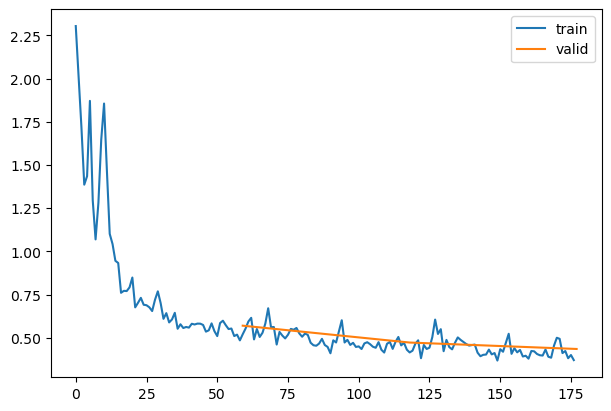

In [18]:
get_learner(SGD).fit(3, lr=0.4)

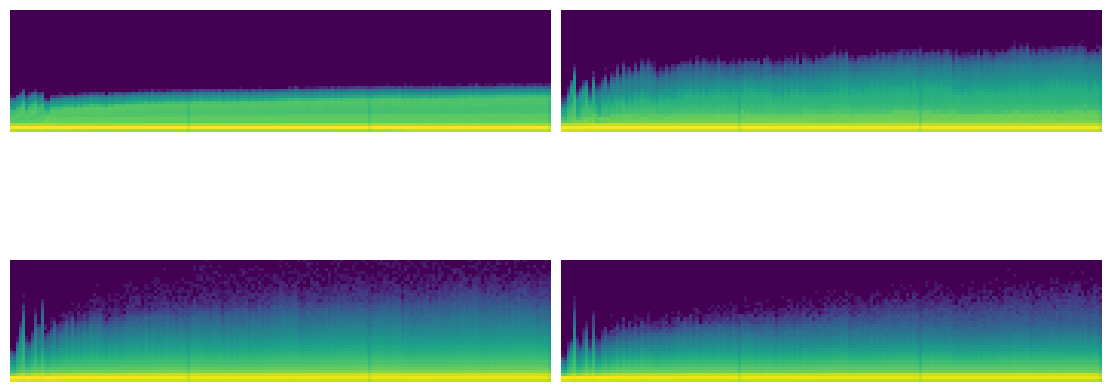

In [19]:
astats.color_dim()

epoch,train,loss,accuracy
0,train,0.7828,0.7267
0,eval,0.4748,0.8281
1,train,0.4108,0.8497
1,eval,0.4131,0.8495
2,train,0.3626,0.8680
2,eval,0.3801,0.8626


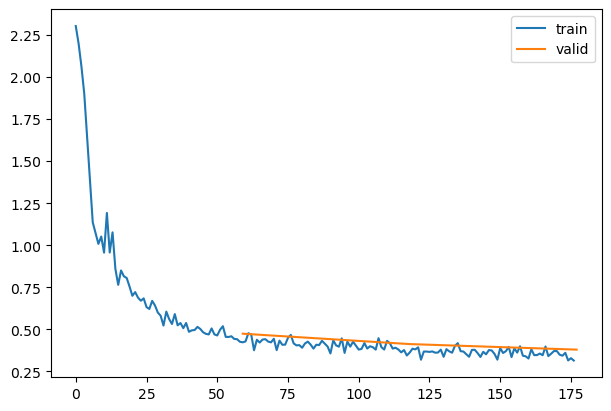

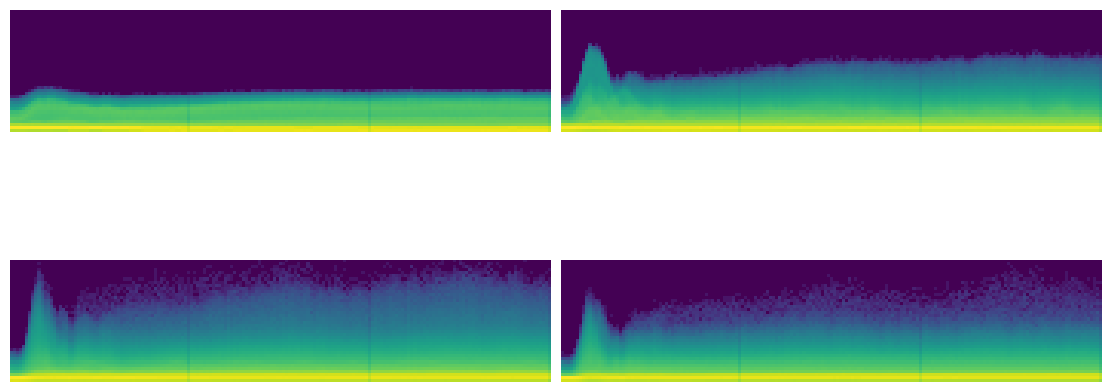

In [20]:
get_learner(Momentum).fit(3, lr=1)
astats.color_dim()

## Schedulers

In [21]:
from torch.optim import lr_scheduler

In [25]:
list(filter(lambda x: x[0].isupper(), dir(lr_scheduler)))

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

epoch,train,loss,accuracy
0,train,0.9021,0.6950
0,eval,0.5923,0.7803


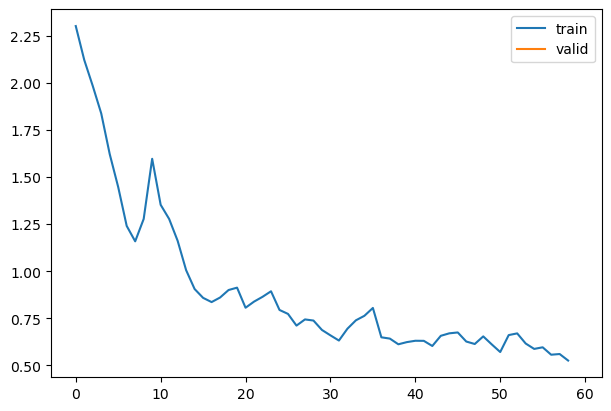

In [234]:
learn = get_learner(optim.SGD)
learn.fit(1)

In [250]:
opt = learn.opt
sched = lr_scheduler.CosineAnnealingLR(opt, 5)
sched = lr_scheduler.CyclicLR(opt, 0.2, 1, 100)

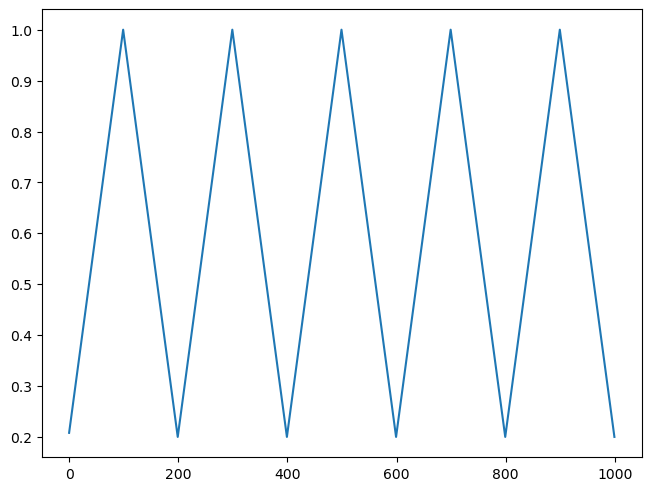

In [251]:
lrs = []
for i in range(1000):
    opt.step()
    sched.step()
    lrs.append(sched.get_last_lr())
    
import matplotlib.pyplot as plt
plt.plot(lrs)

In [200]:
sched.step()
sched.get_lr()

[0.1996547991712306]

In [185]:
sched.optimizer.state[next(iter(learn.model.parameters()))]

{'momentum_buffer': None}

In [191]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[[[-0.216,  0.742,  0.095],
             [-0.274, -0.649, -0.083],
             [-0.192,  0.320,  0.706]]],
   
   
           [[[ 0.418,  0.777,  0.330],
             [ 0.041,  0.100, -0.482],
             [ 0.451,  0.017,  0.042]]],
   
   
           [[[ 0.451, -0.287, -0.184],
             [-0.521,  0.486,  0.086],
             [-0.665,  0.006, -0.605]]],
   
   
           [[[-0.147, -0.628, -0.136],
             [-0.020, -0.992,  0.375],
             [-0.031, -0.622,  0.142]]],
   
   
           [[[ 0.419, -0.029, -0.069],
             [-0.255,  0.353,  0.119],
             [ 0.507,  0.039, -0.695]]],
   
   
           [[[ 0.772,  0.909,  0.693],
             [ 0.936,  0.016,  0.700],
             [ 0.237,  0.046, -0.897]]],
   
   
           [[[ 0.143,  0.788,  0.359],
             [ 1.283, -0.156, -0.633],
             [ 0.498,  0.924, -0.218]]],
   
   
           [[[-0.313, -0.062,  0.574],
             [-0.413, -0.804, -0.711]

## One Cycle Training

In [41]:
bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

In [99]:
learn = get_learner(optim.AdamW)

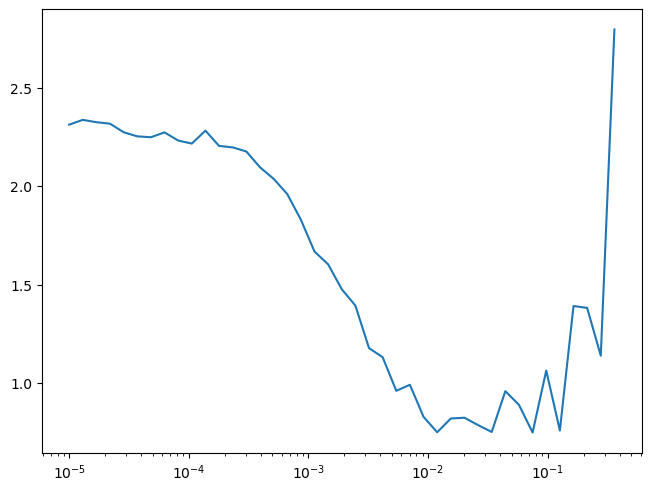

In [62]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,0.5107,0.8178
0,eval,0.5483,0.8280
1,train,0.3927,0.8584
1,eval,0.4588,0.8363
2,train,0.3225,0.8829
2,eval,0.4515,0.8493
3,train,0.2703,0.9006
3,eval,0.2926,0.8961
4,train,0.2136,0.9214
4,eval,0.2718,0.9016


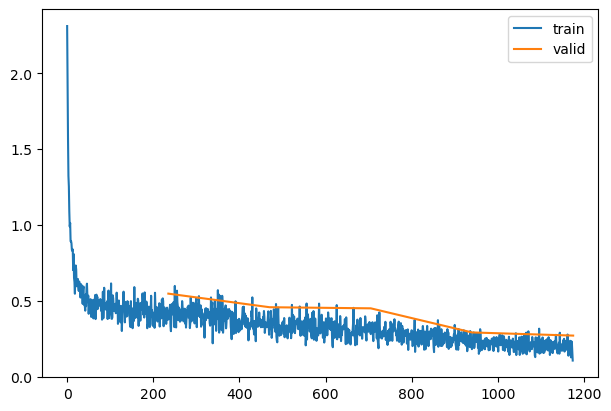

In [100]:
def _lr(learn):
    return learn.opt.param_groups[0]['lr']

def _beta1(learn):
    return learn.opt.param_groups[0]['betas'][0]

def _beta2(learn):
    return learn.opt.param_groups[0]['betas'][1]


nepochs = 5
# max_lr = 3e-3
max_lr = 6e-2
tmax = len(dls.train) * nepochs

rec = RecorderCB(lr=_lr, beta1=_beta1, beta2=_beta2)
sched = partial(optim.lr_scheduler.OneCycleLR, max_lr=max_lr, total_steps=tmax)
learn.fit(nepochs, lr=3e-3, cbs=[BatchSchedCB(sched), rec])

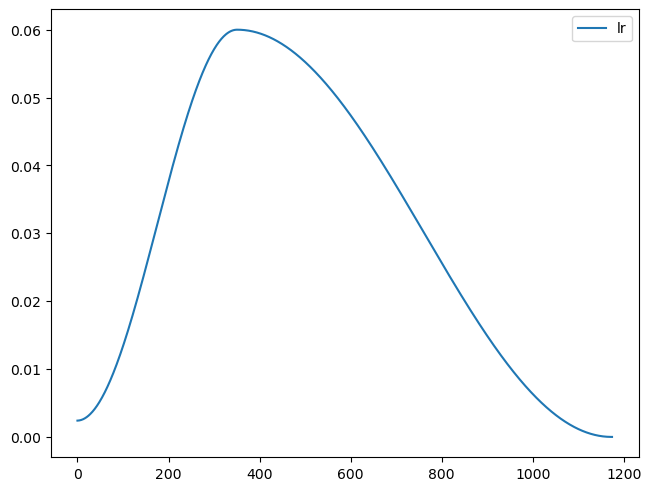

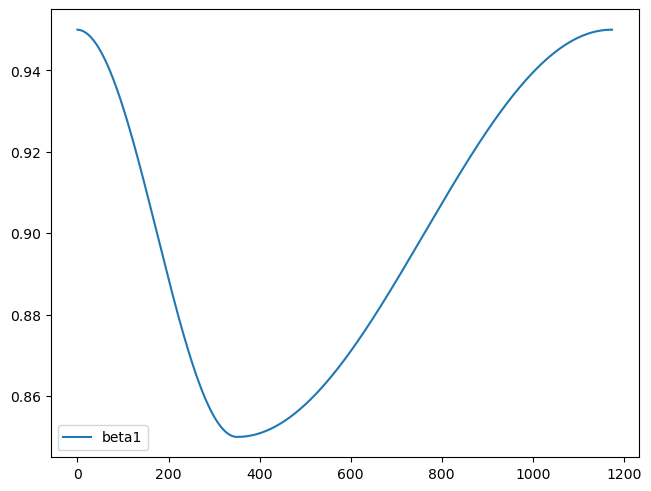

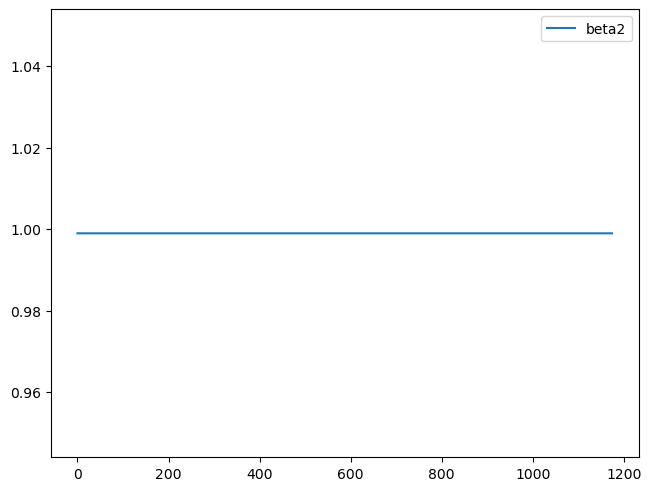

In [101]:
rec.plot()

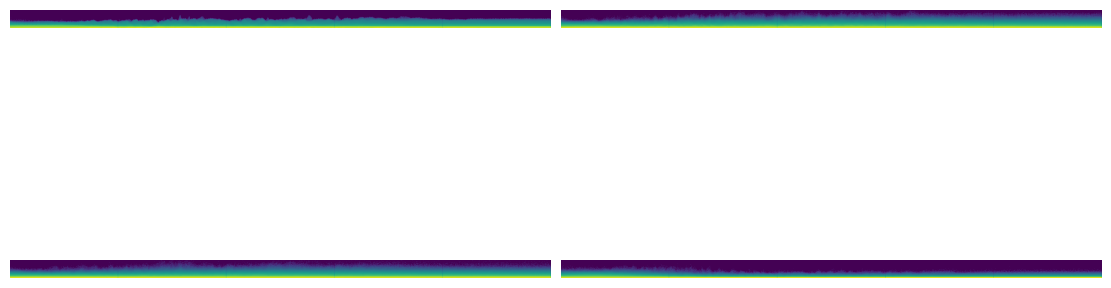

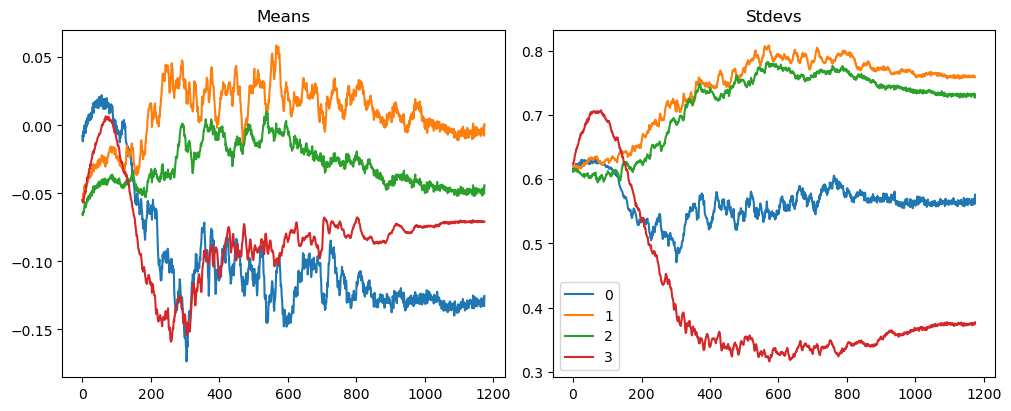

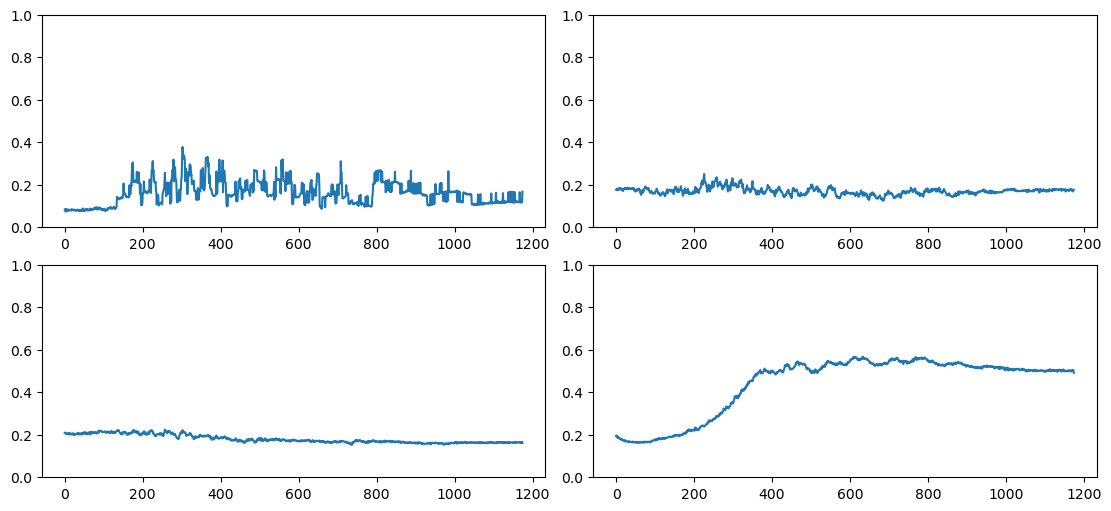

In [102]:
astats.plot_all()

epoch,train,loss,accuracy
0,train,0.1977,0.9269
0,eval,0.2713,0.9024
1,train,0.1937,0.9282
1,eval,0.2711,0.9026
2,train,0.1907,0.9296
2,eval,0.2710,0.9021
3,train,0.1878,0.9308
3,eval,0.2708,0.9025
4,train,0.1850,0.9318
4,eval,0.2710,0.9025


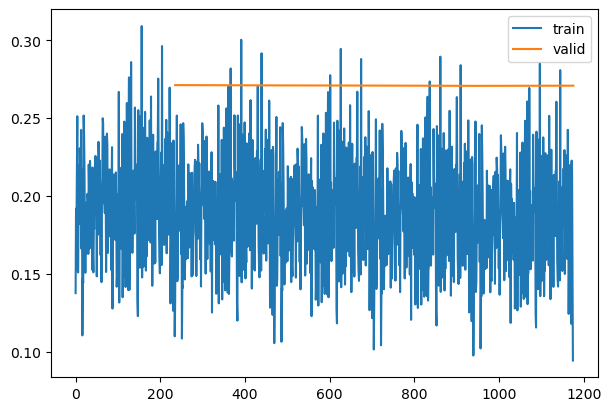

In [103]:
learn.fit(nepochs, lr=6e-4)